In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import matplotlib.pyplot as plt

import math
import numpy as np
import pandas as pd
import seaborn as sns

#from sklearn.metrics import accuracy_score, log_loss
#from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
#from torch.optim import Adam, SGD
import torch.utils.checkpoint as checkpoint

import torchvision
from torchvision.transforms import v2

import warnings
#import time
#import functools
#import copy

seed = 1001
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)
warnings.simplefilter('ignore', UserWarning)

In [2]:
import torchquantum as tq
from torchquantum.measurement import expval_joint_analytical

In [3]:
print(torch.__version__)
print(tq.__version__)

2.5.1+cu124
0.1.7


In [4]:
n_gpu = torch.cuda.device_count()
print(n_gpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print([torch.cuda.get_device_name('cuda:'+str(i)) for i in range(n_gpu)])

1
['NVIDIA GeForce RTX 4090']


In [5]:
data = torchvision.datasets.MNIST(root='./data', train=True, download=True)
data_tr, label_tr = data.train_data, data.train_labels
data = torchvision.datasets.MNIST(root='./data', train=False, download=True)
data_te, label_te = data.test_data, data.test_labels
print(data_tr.shape, data_te.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


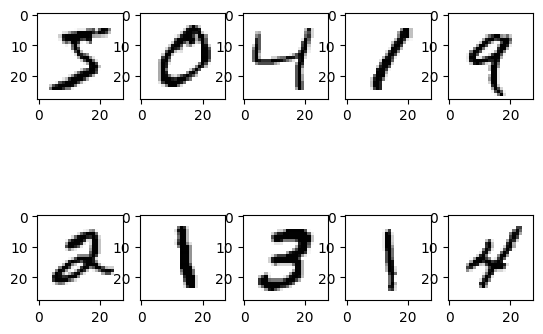

In [6]:
num = 10
for i in range(num):
    ax = plt.subplot(2,num//2,i+1)
    ax.imshow(data_tr[i].detach().numpy(), cmap='gray_r')

In [7]:
dataset_name = 'mnist'
n_class = len(np.unique(label_tr))

In [8]:
n_qubits = 8
n_depth_per_block = 50
n_qnn = 9

#assert n_qubits%2==0
n_half_qubits = n_qubits//2 # 4
n_latter_half_qubits = n_qubits-n_half_qubits

In [9]:
class ConstCoeffLayer(nn.Module):
    def __init__(self, coeff):
        super().__init__()
        self.coeff = coeff
    def forward(self, x):
        ret = x * self.coeff
        return ret

In [10]:
def calc_exp_val(qdev, obs):
    assert len(obs)==n_qubits
    state2 = qdev.states.clone()
    for i in range(n_qubits):
        if obs[i]=='I':
            continue
        elif obs[i]=='X':
            mat = torch.tensor([[0,1],[1,0]])
        elif obs[i]=='Y':
            mat = torch.tensor([[0,-1j],[1j,0]])
        elif obs[i]=='Z':
            mat = torch.tensor([[1,0],[0,-1]])
        state2 = tq.functional.apply_unitary_bmm(state2, mat, [i])
    state1 = qdev.states.clone()
    exp_val = torch.einsum("bij...k,bij...k->b", state1.conj(), state2).real
    # to confirm the calculation of expectation values
    if False:
        bra = qdev.get_states_1d().clone().conj()
        ket = torch.reshape(state2, [bsz, 2**n_qubits])
        tmp_exp_val = torch.sum(bra*ket,dim=1).real # (bsz,dim) => (bsz)
        assert np.allclose(tmp_exp_val.detach().cpu().numpy(),exp_val.detach().cpu().numpy(),rtol=1e-5,atol=1e-5)
    return exp_val

In [11]:
# 14x14 => 7x14x2
# 2n_qubitsx28 => 14x7x8 = 14x28x2
class QNNsubModel(nn.Module):
    def __init__(self):
        # params is numpy array
        super().__init__()

    def forward(self, x, phi):
        bsz, nx_features = x.shape
        qdev = tq.QuantumDevice(
            n_wires=n_qubits, bsz = bsz, device=x.device, record_op=False
        )
        for k in range(n_depth_per_block):
            # j = 2*d*n_depth_per_block + 2*k
            for i in range(n_qubits):
                tq.functional.rx(qdev, wires=i, params=phi[i+2*k*n_qubits])
            for i in range(n_qubits):
                tq.functional.ry(qdev, wires=i, params=phi[i+(2*k+1)*n_qubits])
            for i in range(n_qubits):
                qdev.cz(wires=[i,(i+1)%n_qubits])
        for i in range(n_qubits): # x: 32, phi: 64
            for j in range(n_half_qubits):
                if j%2==0:
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+2*n_depth_per_block*n_qubits])
                    tq.functional.rx(qdev, wires=i, params=x[:,n_half_qubits*i+j]) ##
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+1+2*n_depth_per_block*n_qubits])
                else:
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+2*n_depth_per_block*n_qubits])
                    tq.functional.ry(qdev, wires=i, params=x[:,n_half_qubits*i+j]) ##
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+1+2*n_depth_per_block*n_qubits])
        for i in range(n_qubits):
            qdev.cz(wires=[i,(i+1)%(n_qubits)])
        for k in range(n_depth_per_block):
            # j = 2*d*n_depth_per_block + 2*k
            for i in range(n_qubits):
                tq.functional.rx(qdev, wires=i, params=phi[i+(2*n_depth_per_block+2*n_half_qubits +2*k)*n_qubits])
            for i in range(n_qubits):
                tq.functional.ry(qdev, wires=i, params=phi[i+(2*n_depth_per_block+2*n_half_qubits +2*k+1)*n_qubits])
            for i in range(n_qubits):
                qdev.cz(wires=[i,(i+1)%n_qubits])
        for i in range(n_qubits): # 32, 64
            for j in range(n_latter_half_qubits):
                if j%2==0:
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
                    tq.functional.rx(qdev, wires=i, params=x[:,n_latter_half_qubits*i+j+n_half_qubits*n_qubits]) ##
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+1+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
                else:
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
                    tq.functional.ry(qdev, wires=i, params=x[:,n_latter_half_qubits*i+j+n_half_qubits*n_qubits]) ##
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+1+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
        for i in range(n_qubits):
            qdev.cz(wires=[i,(i+1)%(n_qubits)])
        j= 2
        for k in range(n_depth_per_block):
            for i in range(n_qubits):
                tq.functional.rx(qdev, wires=i, params=phi[i+(4*n_depth_per_block+2*n_qubits +2*k)*n_qubits])
            for i in range(n_qubits):
                tq.functional.ry(qdev, wires=i, params=phi[i+(4*n_depth_per_block+2*n_qubits +2*k+1)*n_qubits])
            if (k==n_depth_per_block-1):
                break
            for i in range(n_qubits):
                qdev.cz(wires=[i,(i+1)%n_qubits])
        obs_list = [ calc_exp_val(qdev, "I"*i+Pauli+"I"*(n_qubits-1-i)) for Pauli in ["X","Z"] for i in range(n_class//2)]
        ret = torch.stack(obs_list, dim=1)
        return ret

In [12]:
# 14x14 => 7x14x2
# 1:8, 7:14 -> 0:7, 6:13
# 1:8, 4:11, 7:14 -> 0:7, 3:10, 6:13
class QNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.params_list = nn.ParameterList([torch.rand( (3*2*n_depth_per_block+2*n_qubits)*n_qubits )*math.pi for _ in range(n_qnn)])
        self.pos_bias = nn.Parameter( torch.zeros(14, 14, device=device) )
        self.qnn_list = [QNNsubModel() for _ in range(n_qnn)]
    def forward(self, x):
        n_data = len(x)
        in_x = x + self.pos_bias
        in_x = torch.stack([ in_x[:,i:i+n_qubits,j:j+n_qubits].reshape(n_data,n_qubits*n_qubits) for i in [0,3,6] for j in [0,3,6] ], axis=0) # (4,n_data,64)
        ret_list = [checkpoint.checkpoint(self.qnn_list[i], in_x[i], self.params_list[i]) for i in range(n_qnn)]
        ret = torch.stack(ret_list, axis=1) # (bsz, n_qnn, n_class)
        ret = torch.mean(ret, axis=1) # (bsz,n_class)
        return ret

In [13]:
def train(data, label, model, accumulation_steps):
    pred = model(data) # (bsz, n_class)
    loss = torch.nn.CrossEntropyLoss()(pred, label)
    loss = loss / accumulation_steps
    loss.backward()
    with torch.no_grad():
        pred_normalized = nn.functional.softmax(pred, dim=1)
        acc = (pred_normalized.argmax(axis=1) == label).sum().item() / len(label)
    print(f"train loss: {loss.item()*accumulation_steps:.5f} train acc: {acc:.3f}", end='\n')
    return loss.item(), acc

def valid(data, label, model):
    with torch.no_grad():
        pred = model(data)
        loss = torch.nn.CrossEntropyLoss()(pred, label)
        pred_normalized = nn.functional.softmax(pred, dim=1)
        acc = (pred_normalized.argmax(axis=1) == label).sum().item() / len(label)
    print(f"valid loss: {loss.item():.5f} valid acc: {acc:.3f}", end='\n')
    return loss.item(), acc

In [14]:
# normalization: /255*math.pi/n_half_qubits=/255*2*math.pi/n_qubits ??
data_tr = data_tr/255*2*math.pi/n_qubits
data_te = data_te/255*2*math.pi/n_qubits

data_tr = torch.nn.AvgPool2d( (2,2), stride=(2,2) )(data_tr) # (28,28) -> (14,14)
data_te = torch.nn.AvgPool2d( (2,2), stride=(2,2) )(data_te) # (28,28) -> (14,14)

#data_tr = data_tr.reshape(-1,data_tr.shape[1]*data_tr.shape[2]) #.detach().numpy()
#data_te = data_te.reshape(-1,data_te.shape[1]*data_te.shape[2]) #.detach().numpy()
print(data_tr.shape, data_te.shape)

torch.Size([60000, 14, 14]) torch.Size([10000, 14, 14])


In [15]:
max_epochs = 50
coeff=100
data_tr, label_tr = data_tr.to(device), label_tr.to(device)
data_te, label_te = data_te.to(device), label_te.to(device)
model = torch.nn.Sequential(
    QNNModel(),
    ConstCoeffLayer(coeff)
)

# すべての点で求めて、手動で各local minimum の点を選ぶ.
prefix_name = dataset_name+"_"+str(n_qnn)+"qnn"+str(n_depth_per_block)+"_c"+str(coeff)+"_"+str(n_qubits)+"qubits_ensembling_cos"
model.load_state_dict(torch.load('./tmp_8qubits_9qnn/'+prefix_name+'_init.pt', weights_only=True))

loss_tr_list = []
loss_te_list = []
model_params_list = []
model_params_np_init = np.array([model[0].params_list[j].detach().cpu().numpy() for j in range(n_qnn)]).flatten()
model_params_list.append(model_params_np_init)
with torch.no_grad():
    pred_tr = model(data_tr)
    loss = torch.nn.CrossEntropyLoss()(pred_tr, label_tr)
    loss_tr_list.append(loss.item())

    pred_te = model(data_te)
    loss = torch.nn.CrossEntropyLoss()(pred_te, label_te)
    loss_te_list.append(loss.item())

for i_epoch in range(max_epochs):
    model.load_state_dict(torch.load('./tmp_8qubits_9qnn/'+prefix_name+'_epoch'+str(i_epoch)+'.pt', weights_only=True))
    model_params_np = np.array([model[0].params_list[j].detach().cpu().numpy() for j in range(n_qnn)]).flatten()
    model_params_list.append(model_params_np)
    with torch.no_grad():
        pred_tr = model(data_tr)
        loss = torch.nn.CrossEntropyLoss()(pred_tr, label_tr)
        loss_tr_list.append(loss.item())
        
        pred_te = model(data_te)
        loss = torch.nn.CrossEntropyLoss()(pred_te, label_te)
        loss_te_list.append(loss.item())

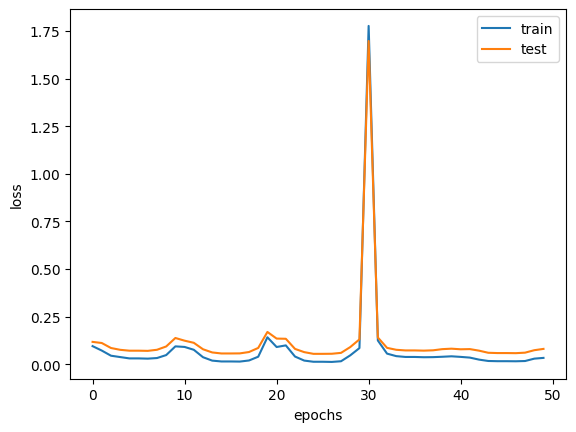

In [16]:
loss_tr_np = np.array(loss_tr_list)
loss_te_np = np.array(loss_te_list)

fig, ax = plt.subplots()
LEN = len(loss_tr_np)
ax.plot(np.arange(LEN-1), loss_tr_np[1:], label='train')
ax.plot(np.arange(LEN-1), loss_te_np[1:], label='test')
# ax.set_title('')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.show()

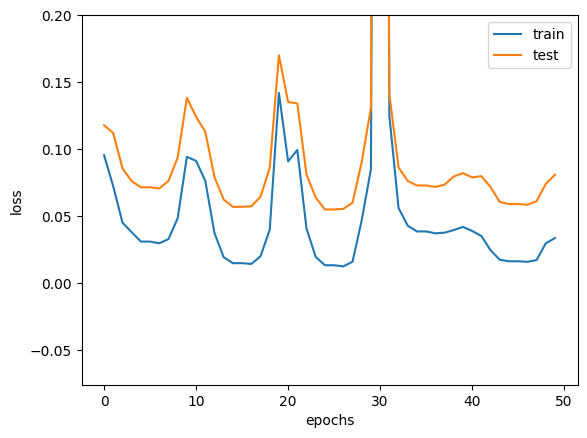

In [17]:
fig, ax = plt.subplots()
LEN = len(loss_tr_np)
ax.plot(np.arange(LEN-1), loss_tr_np[1:], label='train')
ax.plot(np.arange(LEN-1), loss_te_np[1:], label='test')
# ax.set_title('')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_ylim(top=0.20)
plt.show()

In [18]:
pd.DataFrame({'epochs': np.arange(LEN)-1, 'train_loss': loss_tr_np, 'test_loss': loss_te_np}).to_csv('./tmp_8qubits_9qnn/losses.csv', index=False)

In [19]:
index_tr = loss_tr_np.argmin()
model = torch.nn.Sequential(
    QNNModel(),
    ConstCoeffLayer(coeff)
)
if index_tr==0:
    model.load_state_dict(torch.load('./tmp_8qubits_9qnn/'+prefix_name+'_init.pt', weights_only=True))
else:
    model.load_state_dict(torch.load('./tmp_8qubits_9qnn/'+prefix_name+'_epoch'+str(index_tr-1)+'.pt', weights_only=True))

model_params_np = np.array(model_params_list)
model_params_orig = model_params_np[index_tr]
# model_params_np = model_params_np - model_params_orig # minimum を基準にして、引き算する。

pca = PCA(n_components=2)
pred_tr_2d = pca.fit_transform(model_params_np) # pca の第一主成分と第二主成分を求める。
pred_2d_orig = pred_tr_2d[index_tr]
pred_tr_2d = pred_tr_2d-pred_2d_orig
pred_tr_2d_max = pred_tr_2d.max(axis=0)
pred_tr_2d_min = pred_tr_2d.min(axis=0)
print(pred_tr_2d_max, pred_tr_2d_min)
print(pca.explained_variance_ratio_)

[ 5.774805 19.603767] [-30.24184    -1.0346456]
[0.8880086  0.07840756]


In [20]:
# 適当な広さをとって、格子点をとって、各点のloss を求める。
N = 20
x1 = np.linspace(pred_tr_2d_min[0]-5, pred_tr_2d_max[0]+5, N)
x2 = np.linspace(pred_tr_2d_min[1]-5, pred_tr_2d_max[1]+5, N)
X1, X2 = np.meshgrid(x1, x2)
X = np.c_[np.ravel(X1), np.ravel(X2)]
LEN = len(X)
Z = []
with torch.no_grad():
    for index in range(LEN): # LEN
        x, y= X[index]
        # parameter 読み出し、変更.
        tmp_model_param = pca.inverse_transform(np.array([x,y])+pred_2d_orig)
        model[0].params_list = nn.ParameterList(tmp_model_param.reshape(n_qnn,-1).tolist())
        pred_tr = model(data_tr)
        loss = torch.nn.CrossEntropyLoss()(pred_tr, label_tr)
        Z.append(loss.item())

In [21]:
if LEN==len(Z):
    pd.DataFrame({'x': X[:,0], 'y': X[:,1], 'train_loss': Z }).to_csv('./tmp_8qubits_9qnn/mesh.csv',index=False)
elif len(Z)<LEN:
    pd.DataFrame({'x': X[:,0], 'y': X[:,1], 'train_loss': Z+[-1e3]*(LEN-len(Z)) }).to_csv('./tmp_8qubits_9qnn/mesh.csv',index=False)

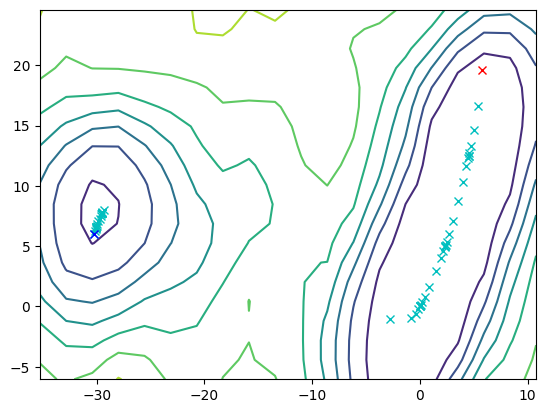

In [22]:
fig, ax = plt.subplots()
if LEN==len(Z):
    CS = ax.contour(X1, X2, np.reshape(Z,X1.shape))
elif len(Z)<LEN:
    CS = ax.contour(X1, X2, np.reshape(Z+[-1]*(LEN-len(Z)),X1.shape))
ax.plot(pred_tr_2d[0,0],pred_tr_2d[0,1],'rx')
ax.plot(pred_tr_2d[1:,0],pred_tr_2d[1:,1],'cx')
ax.plot(pred_tr_2d[-1,0],pred_tr_2d[-1,1],'bx')

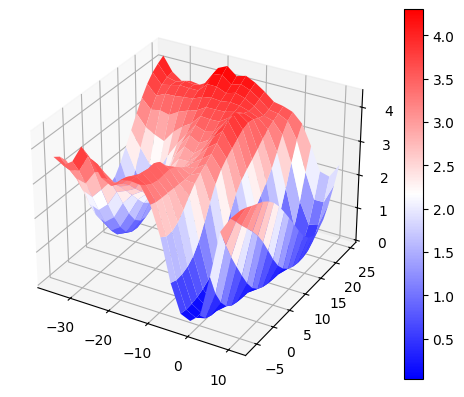

In [23]:
# 3d plot する. 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
if LEN==len(Z):
    surf = ax.plot_surface(X1, X2, np.reshape(Z, X1.shape), cmap='bwr', linewidth=0)
elif len(Z)<LEN:
    surf = ax.plot_surface(X1, X2, np.reshape(Z+[-1]*(LEN-len(Z)), X1.shape), cmap='bwr', linewidth=0)
fig.colorbar(surf)
#ax.set_title("Surface Plot")
fig.show()

In [24]:
local_min_index = [6,15,25,36,46]

In [25]:
with torch.no_grad():
    pred_tr_list = []
    pred_te_list = []
    for index in local_min_index:
        model = torch.nn.Sequential( QNNModel(), ConstCoeffLayer(coeff))
        if index==0:
            model.load_state_dict(torch.load('./tmp_8qubits_9qnn/'+prefix_name+'_init.pt', weights_only=True))
        else:
            model.load_state_dict(torch.load('./tmp_8qubits_9qnn/'+prefix_name+'_epoch'+str(index-1)+'.pt', weights_only=True))
        pred_tr = model(data_tr)
        pred_te = model(data_te)
        pred_tr_list.append(pred_tr)
        pred_te_list.append(pred_te)
    pred_tr = torch.stack(pred_tr_list, axis=1) # n_data, n_model, n_class
    pred_tr = torch.mean(pred_tr, axis=1) # n_data, n_class
    loss = torch.nn.CrossEntropyLoss()(pred_tr, label_tr)
    pred_tr_normalized = nn.functional.softmax(pred_tr, dim=1)
    acc_tr = (pred_tr_normalized.argmax(axis=1) == label_tr).sum().item() / len(label_tr)
    print(f"ensemble: train loss: {loss.item():.5f} train acc: {acc_tr:.3f}", end='\n')
    pred_te = torch.stack(pred_te_list, axis=1) # n_data, n_model, n_class
    pred_te = torch.mean(pred_te, axis=1) # n_data, n_class
    loss = torch.nn.CrossEntropyLoss()(pred_te, label_te)
    pred_te_normalized = nn.functional.softmax(pred_te, dim=1)
    acc_te = (pred_te_normalized.argmax(axis=1) == label_te).sum().item() / len(label_te)
    print(f"ensemble: valid loss: {loss.item():.5f} valid acc: {acc_te:.3f}", end='\n')

ensemble: train loss: 0.01612 train acc: 0.997
ensemble: valid loss: 0.05020 valid acc: 0.984
